# HGT Models to Compute Heritage Values and Attributes

## Imports

In [1]:
import os
import os.path as osp
from itertools import product
from typing import Callable, List, Optional

import numpy as np
import scipy.sparse as sp

from torch_geometric.data import (
    HeteroData,
    InMemoryDataset,
    download_url,
    extract_zip,
)

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import pandas as pd

import random

import torch
torch.manual_seed(1337)
torch.backends.cudnn.benchmark = True

from torch_geometric.transforms import RandomLinkSplit, ToUndirected
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, Linear, to_hetero
from torch_geometric.utils import to_undirected

import torch.nn.functional as F
from torch_geometric import seed_everything

from tqdm import tqdm
import torch.optim as optim
import pickle

In [3]:
from torch_geometric.nn import  HGTConv, Linear

In [4]:
os.getcwd()

'D:\\surf\\TUD\\Paper\\Venice_Graph'

In [5]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.10.2
GPU-enabled installation? True


In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [8]:
args = Namespace(
    # Data and Path information
    path = 'dataset/Venice',
    save_dir='model_storage/HGT/',
    model_state_file='model.pth',
    
    # Model hyper parameters
    hidden_channels = 128,
    num_layers = 3,
    num_heads = 2,
    group = 'sum',
    k=3,
    
    # Training hyper parameters
    sample_nodes = 25,
    batch_size=32,
    early_stopping_criteria=100,
    learning_rate=0.001,
    l2=2e-4,
    dropout_p=0.5,
    num_epochs=300,
    seed=42,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

In [9]:
if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# handle dirs
handle_dirs(args.save_dir)    

Expanded filepaths: 
	model_storage/HGT/model.pth


## Constructing Dataset

In [10]:
class VEN(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (1,190 nodes), nodes with both visual and textual
    features 'vis_tex' (1,761 nodes) and four types of links - social similarity
    'SOC' (488,103 links), spatial similarity (445,779 links), temporal similarity
    (501,191 links), and simple composed link (1,071,977 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [10]:
class VEN_links(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (1,190 nodes), nodes with both visual and textual
    features 'vis_tex' (1,761 nodes) and four types of links - social similarity
    'SOC' (488,103 links), spatial similarity (445,779 links), temporal similarity
    (501,191 links), and simple composed link (1,071,977 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['all']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        #data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        #data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        #data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        #data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        #data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        #data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data['all'].node_type = node_type_idx
        
        data['all'].att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data['all'].val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            #data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            #data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        #s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        #s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [12]:
class VEN_XL(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1QZ5tyUWs6jYjh7mJrsnpou76iy-vb0CA'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [10]:
class VEN_XL_Links(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1QZ5tyUWs6jYjh7mJrsnpou76iy-vb0CA'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['all']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        #data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        #data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        #data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        #data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        #data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        #data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data['all'].node_type = node_type_idx
        
        data['all'].att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data['all'].val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            #data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            #data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        #s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        #s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [11]:
#path = osp.join(os.getcwd(), '../../data/VEN')
dataset = VEN_links('dataset/Venice_links')
data = dataset[0]

In [12]:
data['all'].n_id = torch.arange(data.num_nodes)
data = data.to(device)
data

HeteroData(
  all={
    num_nodes=2951,
    x=[2951, 1753],
    y=[2951, 20],
    node_type=[2951],
    att_lab=[2951],
    val_lab=[2951],
    train_mask=[2951],
    val_mask=[2951],
    test_mask=[2951],
    n_id=[2951]
  },
  (all, SOC_link, all)={
    edge_index=[2, 488103],
    edge_attr=[488103]
  },
  (all, SPA_link, all)={
    edge_index=[2, 445779],
    edge_attr=[445779]
  },
  (all, TEM_link, all)={
    edge_index=[2, 501191],
    edge_attr=[501191]
  },
  (all, simp_link, all)={
    edge_index=[2, 1071977],
    edge_attr=[1071977]
  }
)

In [13]:
data['all']['train_mask'].sum()

tensor(361, device='cuda:0')

## Data Loader for Sampling

In [14]:
from torch_geometric.loader import NeighborLoader

In [15]:
data.edge_types

[('all', 'SOC_link', 'all'),
 ('all', 'SPA_link', 'all'),
 ('all', 'TEM_link', 'all'),
 ('all', 'simp_link', 'all')]

In [16]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)

In [17]:
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)

In [18]:
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [19]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2950,
    x=[2950, 1753],
    y=[2950, 20],
    node_type=[2950],
    att_lab=[2950],
    val_lab=[2950],
    train_mask=[2950],
    val_mask=[2950],
    test_mask=[2950],
    n_id=[2950],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 26610],
    edge_attr=[26610]
  },
  (all, SPA_link, all)={
    edge_index=[2, 28393],
    edge_attr=[28393]
  },
  (all, TEM_link, all)={
    edge_index=[2, 26680],
    edge_attr=[26680]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [20]:
batch['all']['train_mask'].sum()

tensor(361, device='cuda:0')

## Helper Function

In [21]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_ATT_acc_val': 0,
            'early_stopping_best_VAL_acc_val': 0,
            'early_stopping_best_ATT_acc_val_2': 0,
            'early_stopping_lowest_loss': 1000,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_ATT_loss': [],
            'train_VAL_loss':[],
            'train_ATT_acc': [],
            'train_VAL_acc': [],
            'train_VAL_jac': [],
            'train_VAL_acc_1':[], 
            'val_loss': [],
            'val_ATT_loss': [],
            'val_VAL_loss':[],
            'val_ATT_acc': [],
            'val_VAL_acc': [],
            'val_VAL_jac': [],
            'val_VAL_acc_1': [],
            'test_loss': -1,
            'test_ATT_loss': -1,
            'test_VAL_loss':-1,
            'test_ATT_acc': -1,
            'test_VAL_acc': -1,
            'test_VAL_jac': -1,
            'test_VAL_acc_1': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        ATT_acc_tm1, ATT_acc_t = train_state['val_ATT_acc'][-2:]
        #ATT_acc_2_tm1, ATT_acc_2_t = train_state['val_ATT_acc_2'][-2:]
        VAL_acc_tm1, VAL_acc_t = train_state['val_VAL_acc'][-2:]
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If accuracy worsened
        #if loss_t >= train_state['early_stopping_lowest_loss']:
        #    train_state['early_stopping_step'] += 1
        
        if ATT_acc_t <= train_state['early_stopping_best_ATT_acc_val'] and VAL_acc_t <= train_state['early_stopping_best_VAL_acc_val']:# and ATT_acc_2_t <= train_state['early_stopping_best_ATT_acc_val_2']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if VAL_acc_t > train_state['early_stopping_best_VAL_acc_val']:
                train_state['early_stopping_best_VAL_acc_val'] = VAL_acc_t
                
            if ATT_acc_t > train_state['early_stopping_best_ATT_acc_val']:
                train_state['early_stopping_best_ATT_acc_val'] = ATT_acc_t
            
            #if ATT_acc_2_t > train_state['early_stopping_best_ATT_acc_val_2']:
            #    train_state['early_stopping_best_ATT_acc_val_2'] = ATT_acc_2_t
                
            if loss_t < train_state['early_stopping_lowest_loss']:
                train_state['early_stopping_lowest_loss'] = loss_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [22]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [23]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

## Searched Best Hyper-Parameter

In [56]:
with open(args.save_dir+'42/hyperdict.p', 'rb') as fp:
    hyperdict= pickle.load(fp)

In [57]:
len(hyperdict)

192

In [58]:
hyper_df = pd.DataFrame(hyperdict).T

In [59]:
hyper_df[(hyper_df.early_stopping_best_VAL_acc_val + hyper_df.early_stopping_best_VAL_acc_val)>196]

stop_early early_stopping_step  \
2 2 sum  64 0.0100       True                 100   
  3 sum  32 0.0010       True                 100   
            0.0005      False                  98   
    mean 32 0.0005       True                 100   
4 3 sum  64 0.0100      False                  95   
  5 sum  32 0.0001       True                 100   

                   early_stopping_best_ATT_acc_val  \
2 2 sum  64 0.0100                       89.064748   
  3 sum  32 0.0010                       89.496403   
            0.0005                       88.920863   
    mean 32 0.0005                       89.208633   
4 3 sum  64 0.0100                       89.640288   
  5 sum  32 0.0001                       88.201439   

                   early_stopping_best_VAL_acc_val  \
2 2 sum  64 0.0100                       98.116416   
  3 sum  32 0.0010                       98.942228   
            0.0005                       98.953564   
    mean 32 0.0005                        98.10508   
4 3 sum  64 0.0100                       98.116416   
  5 sum  32 0.0001                       98.314367   

                   early_stopping_best_ATT_acc_val_2  \
2 2 sum  64 0.0100                                 0   
  3 sum  32 0.0010                                 0   
            0.0005                                 0   
    mean 32 0.0005                                 0   
4 3 sum  64 0.0100                                 0   
  5 sum  32 0.0001                                 0   

                   early_stopping_lowest_loss learning_rate epoch_index  \
2 2 sum  64 0.0100                   4.260714          0.01         238   
  3 sum  32 0.0010                   4.207492         0.001         252   
            0.0005                   4.223594        0.0005         299   
    mean 32 0.0005                   4.238065        0.0005         238   
4 3 sum  64 0.0100                   4.250843          0.01         299   
  5 sum  32 0.0001                   4.251635        0.0001         285   

                                                           train_loss  \
2 2 sum  64 0.0100  [4.073777973651886, 3.071266452471415, 2.70923...   
  3 sum  32 0.0010  [4.071910460789998, 3.4655648271242776, 3.2366...   
            0.0005  [4.231941819190979, 3.713909467061361, 3.45286...   
    mean 32 0.0005  [4.248942116896312, 3.837139884630839, 3.53874...   
4 3 sum  64 0.0100  [4.173254390557607, 2.9642478823661804, 2.6236...   
  5 sum  32 0.0001  [4.508403778076172, 4.371051947275798, 4.22484...   

                                                       train_ATT_loss  ...  \
2 2 sum  64 0.0100  [1.5183023914405844, 1.0559576274285356, 0.904...  ...   
  3 sum  32 0.0010  [1.788339904470787, 1.5794255941528363, 1.3938...  ...   
            0.0005  [1.9538542296417531, 1.7716821270306025, 1.613...  ...   
    mean 32 0.0005  [1.972144102125617, 1.784775425852831, 1.62302...  ...   
4 3 sum  64 0.0100  [1.4151781909683734, 0.95903942459508, 0.84767...  ...   
  5 sum  32 0.0001  [2.1526270024994405, 2.085895083947855, 2.0104...  ...   

                                                          val_VAL_jac  \
2 2 sum  64 0.0100  [0.26566383523153075, 0.3079354757937258, 0.31...   
  3 sum  32 0.0010  [0.2376455202803311, 0.259545095542274, 0.2871...   
            0.0005  [0.06249400512881598, 0.21880968061022593, 0.2...   
    mean 32 0.0005  [0.051972967413533654, 0.11621103192352897, 0....   
4 3 sum  64 0.0100  [0.2324700263093857, 0.3140731074988309, 0.317...   
  5 sum  32 0.0001  [0.0, 0.0, 0.0, 0.0, 0.0, 0.031393067364290386...   

                                                        val_VAL_acc_1  \
2 2 sum  64 0.0100  [43.413124046217575, 36.670590800087204, 39.42...   
  3 sum  32 0.0010  [29.764115979943316, 34.3684325267059, 36.0313...   
            0.0005  [14.242860257248745, 29.35687813385655, 34.577...   
    mean 32 0.0005  [14.452147373010682, 18.649226073686503, 34.15...   
4 3 sum  64 0.0100  [41.7274907346

In [60]:
hyper_df[(hyper_df.early_stopping_lowest_loss<4.19)]

,,,,,stop_early,early_stopping_step,early_stopping_best_ATT_acc_val,early_stopping_best_VAL_acc_val,early_stopping_best_ATT_acc_val_2,early_stopping_lowest_loss,learning_rate,epoch_index,train_loss,train_ATT_loss,...,val_VAL_jac,val_VAL_acc_1,test_loss,test_ATT_loss,test_VAL_loss,test_ATT_acc,test_VAL_acc,test_VAL_jac,test_VAL_acc_1,model_filename
4,2,sum,128,0.0005,True,100,90.503597,92.861565,0,4.188147,0.0005,276,"[3.8720219135284424, 3.336054523785909, 3.0626...","[1.72003666383738, 1.4708360638314668, 1.24814...",...,"[0.2638441987180076, 0.30983068525232427, 0.33...","[52.62175713974275, 43.20383693045563, 42.1233...",-1,-1,-1,-1,-1,-1,-1,model_storage/HGT/model.pth


## Re-run Model and get Inference Data

In [24]:
class HGT_L(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_heads, num_layers, group='sum'):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        
        self.lin_dict['all'] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        
        metadata = (metadata[0], metadata[-1][:-1])
        
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, metadata,
                           num_heads, group=group)
            self.convs.append(conv)
        
        self.lin1 = Linear(-1, hidden_channels)
        self.lin2 = Linear(2*hidden_channels, out_channels)


    def forward(self, x_dict, edge_index_dict):
        
        x_0 = self.lin1(x_dict['all']).relu()
        
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items() if node_type=='all'
        }

        edge_index_dict = {key: edge_index_dict[key] for key in edge_index_dict if 'all' in key and not 'simp_link' in key}
                           
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            
        x = self.lin2(torch.hstack([x_0,x_dict['all']]))
        return x

In [25]:
@torch.no_grad()
def init_params(model, train_loader):
    # Initialize lazy parameters via forwarding a single batch to the model:
    batch = next(iter(train_loader))
    batch = batch.to(device)
    batch = batch.to(device, 'edge_index')
    out = model(batch.x_dict, batch.edge_index_dict)

def train(model, optimizer, train_loader):
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = args.batch_size
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict
        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        y = batch.y_dict['all']
        y_att = y[:,:9]
        y_val = y[:,9:]
        
        loss = F.cross_entropy(out_att, y_att[:batch_size]) + F.cross_entropy(out_val, y_val[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [26]:
@torch.no_grad()
def test(model, loader, mode='train'):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    running_1_val = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch['all'].batch_size
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict

        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch['all'].att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch['all'].val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y_dict['all']
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]

    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val

In [17]:
def initialization():
    set_seed_everywhere(args.seed, args.cuda)
    #transform = T.Compose([T.ToSparseTensor()])
    dataset = VEN_links('dataset/Venice_links')
    data = dataset[0].to(device)
    
    train_loader = NeighborLoader(
        data,
        # Sample 30 neighbors for each node and edge type for 2 iterations
        num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
        # Use a batch size of 128 for sampling training nodes of type paper
        batch_size=args.batch_size,
        input_nodes=('all', data['all'].train_mask),
    )
    val_loader = NeighborLoader(
        data,
        # Sample 30 neighbors for each node and edge type for 2 iterations
        num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
        # Use a batch size of 128 for sampling training nodes of type paper
        batch_size=args.batch_size,
        input_nodes=('all', data['all'].val_mask),
    )
    test_loader = NeighborLoader(
        data,
        # Sample 30 neighbors for each node and edge type for 2 iterations
        num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
        # Use a batch size of 128 for sampling training nodes of type paper
        batch_size=args.batch_size,
        input_nodes=('all', data['all'].test_mask),
    )
 
    model = HGT_L(data.metadata(), hidden_channels=32, out_channels=data.y_dict['all'].shape[-1],
                  num_layers=3, num_heads = 2, group='mean').to(device)
    return data, model, train_loader, val_loader, test_loader

In [18]:
def training_loop(verbose=False):
    
    _, model, train_loader, val_loader, test_loader = initialization()
    if torch.cuda.device_count() > 1:
        print("Use {} GPUs !".format(torch.cuda.device_count()))
        model = DataParallel(model)
    
    init_params(model, train_loader)
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=args.l2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    #                                           mode='min', factor=0.5,
    #                                           patience=1)

    train_state = make_train_state(args)

    try:
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            
            loss = train(model, optimizer, train_loader)
            train_loss_att, train_loss_val, train_att_acc, train_val_acc, train_val_jac, train_val_1 = test(model, train_loader)
            val_loss_att, val_loss_val, val_att_acc, val_val_acc, val_val_jac, val_val_1 = test(model, val_loader, 'val')
            if verbose:
                print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train_ATT: {train_att_acc:.4f}, Train_VAL: {train_val_acc:.4f}, Val_vis_tex_ATT: {val_att_acc:.4f}, Val_vis_tex_VAL: {val_val_acc:.4f}')
            
            train_state['train_loss'].append(loss)
            train_state['train_ATT_loss'].append(train_loss_att)
            train_state['train_VAL_loss'].append(train_loss_val)
            train_state['train_ATT_acc'].append(train_att_acc)
            train_state['train_VAL_acc'].append(train_val_acc)
            train_state['train_VAL_jac'].append(train_val_jac)
            train_state['train_VAL_acc_1'].append(train_val_1)
            
            train_state['val_ATT_loss'].append(val_loss_att)
            train_state['val_VAL_loss'].append(val_loss_val)
            train_state['val_loss'].append(val_loss_att + 3*val_loss_val)
            train_state['val_ATT_acc'].append(val_att_acc)
            train_state['val_VAL_acc'].append(val_val_acc)
            train_state['val_VAL_jac'].append(val_val_jac)
            train_state['val_VAL_acc_1'].append(val_val_1)
            
            train_state = update_train_state(args=args, model=model,
                                                train_state=train_state)
            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [ ]:
train_state = training_loop(verbose=True)

In [26]:
model = HGT_L(data.metadata(), hidden_channels=32, out_channels=data.y_dict['all'].shape[-1],
                  num_layers=3, num_heads = 2, group='mean').to(device)

In [27]:
model.load_state_dict(torch.load(args.save_dir+'HGT_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [28]:
model

HGT_L(
  (lin_dict): ModuleDict(
    (all): Linear(1753, 32, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(-1, 32, heads=2)
    (1): HGTConv(-1, 32, heads=2)
    (2): HGTConv(-1, 32, heads=2)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [34]:
set_seed_everywhere(args.seed, args.cuda)
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 29.38it/s]


In [35]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.49it/s]


(0.725351293496478,
 1.5993330835305422,
 100.0,
 100.0,
 0.872576187852347,
 90.30470914127424)

In [36]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader, 'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 32.42it/s]


(0.8408805747342304,
 1.6251420863156247,
 96.95121951219512,
 98.0295566502463,
 0.738095243576125,
 79.3103448275862)

In [37]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader, 'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 31.41it/s]


(0.8526318166886362,
 1.6444950339694817,
 96.42147117296223,
 99.47916666666667,
 0.740451397995154,
 78.64583333333333)

In [38]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader, 'val'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader, 'val'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.08it/s]


In [39]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [40]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,1.000000e+01
mean,0.840882,1.625143,9.695122e+01,9.802956e+01,0.738095,7.931034e+01
std,0.000002,0.000002,1.497956e-14,1.497956e-14,0.000000,1.497956e-14
min,0.840878,1.625140,9.695122e+01,9.802956e+01,0.738095,7.931034e+01
25%,0.840879,1.625142,9.695122e+01,9.802956e+01,0.738095,7.931034e+01
50%,0.840882,1.625143,9.695122e+01,9.802956e+01,0.738095,7.931034e+01
75%,0.840883,1.625144,9.695122e+01,9.802956e+01,0.738095,7.931034e+01
max,0.840884,1.625148,9.695122e+01,9.802956e+01,0.738095,7.931034e+01


In [41]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,1.000000e+01,1.000000e+01
mean,0.852633,1.644495,96.421471,9.947917e+01,7.404514e-01,7.864583e+01
std,0.000001,0.000003,0.000000,1.497956e-14,1.170278e-16,1.497956e-14
min,0.852631,1.644491,96.421471,9.947917e+01,7.404514e-01,7.864583e+01
25%,0.852633,1.644493,96.421471,9.947917e+01,7.404514e-01,7.864583e+01
50%,0.852633,1.644494,96.421471,9.947917e+01,7.404514e-01,7.864583e+01
75%,0.852634,1.644497,96.421471,9.947917e+01,7.404514e-01,7.864583e+01
max,0.852636,1.644499,96.421471,9.947917e+01,7.404514e-01,7.864583e+01


In [42]:
val_df.to_csv(args.save_dir + 'val_metrics.csv', sep='\t')
test_df.to_csv(args.save_dir + 'test_metrics.csv', sep='\t')

In [43]:
train_state['test_ATT_loss']=test_loss_att
train_state['test_VAL_loss']=test_loss_val
train_state['test_loss']=test_loss_att + 3*test_loss_val
train_state['test_ATT_acc']=test_att_acc
train_state['test_VAL_acc_1']=test_val_1
train_state['test_VAL_acc']=test_val_acc
train_state['test_VAL_jac']=test_val_jac

In [44]:
train_state

{'stop_early': False,
 'early_stopping_step': 55,
 'early_stopping_best_ATT_acc_val': 96.95121951219512,
 'early_stopping_best_VAL_acc_val': 100.0,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.716309051993083,
 'learning_rate': 0.001,
 'epoch_index': 299,
 'train_loss': [4.212754587332408,
  3.744509994983673,
  3.4710254867871604,
  3.263322631518046,
  3.1269689798355103,
  2.989909013112386,
  2.8954469362894693,
  2.8212348222732544,
  2.7362569173177085,
  2.674421548843384,
  2.6485327084859214,
  2.5981449484825134,
  2.576626718044281,
  2.550933837890625,
  2.535131653149923,
  2.484558125336965,
  2.4908601442972818,
  2.476132074991862,
  2.4557361006736755,
  2.4715222318967185,
  2.4546250303586326,
  2.4369125167528787,
  2.4401920239130654,
  2.4267801443735757,
  2.422055800755819,
  2.4224125146865845,
  2.4179813067118325,
  2.4229325453440347,
  2.4207166830698648,
  2.404494285583496,
  2.405641794204712,
  2.4137187401453652,
  2.410827

In [45]:
with open(args.save_dir+'HGT_best_model/best_config.p', 'wb') as fp:
    pickle.dump(train_state,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
with open(args.save_dir+'HGT_best_model/best_config.p', 'rb') as fp:
    train_state = pickle.load(fp)

In [47]:
train_state

{'stop_early': False,
 'early_stopping_step': 55,
 'early_stopping_best_ATT_acc_val': 96.95121951219512,
 'early_stopping_best_VAL_acc_val': 100.0,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.716309051993083,
 'learning_rate': 0.001,
 'epoch_index': 299,
 'train_loss': [4.212754587332408,
  3.744509994983673,
  3.4710254867871604,
  3.263322631518046,
  3.1269689798355103,
  2.989909013112386,
  2.8954469362894693,
  2.8212348222732544,
  2.7362569173177085,
  2.674421548843384,
  2.6485327084859214,
  2.5981449484825134,
  2.576626718044281,
  2.550933837890625,
  2.535131653149923,
  2.484558125336965,
  2.4908601442972818,
  2.476132074991862,
  2.4557361006736755,
  2.4715222318967185,
  2.4546250303586326,
  2.4369125167528787,
  2.4401920239130654,
  2.4267801443735757,
  2.422055800755819,
  2.4224125146865845,
  2.4179813067118325,
  2.4229325453440347,
  2.4207166830698648,
  2.404494285583496,
  2.405641794204712,
  2.4137187401453652,
  2.410827

In [48]:
states = pd.DataFrame(train_state['val_VAL_acc'], columns=['val_VAL'])
states['train_VAL'] = pd.DataFrame(train_state['train_VAL_acc'])
states['val_ATT'] = pd.DataFrame(train_state['val_ATT_acc'])
states['train_ATT'] = pd.DataFrame(train_state['train_ATT_acc'])
states['val_VAL_1'] = pd.DataFrame(train_state['val_VAL_acc_1'])
states['train_VAL_1'] = pd.DataFrame(train_state['train_VAL_acc_1'])
states['train_VAL_jac'] = pd.DataFrame(train_state['train_VAL_jac'])
states['val_VAL_jac'] = pd.DataFrame(train_state['val_VAL_jac'])

In [49]:
states

,val_VAL,train_VAL,val_ATT,train_ATT,val_VAL_1,train_VAL_1,train_VAL_jac,val_VAL_jac
0,71.428571,74.238227,30.894309,28.254848,23.645320,26.315789,0.096953,0.097701
1,88.669951,89.473684,50.609756,47.922438,55.172414,49.030471,0.242382,0.245484
2,93.596059,91.412742,57.317073,59.833795,66.502463,55.678670,0.415512,0.499179
3,95.566502,94.182825,63.414634,72.853186,68.965517,63.988920,0.522161,0.596880
4,97.044335,94.182825,67.073171,76.731302,71.428571,64.819945,0.538319,0.628900
...,...,...,...,...,...,...,...,...
295,98.029557,99.722992,95.731707,100.000000,78.325123,86.703601,0.876731,0.729064
296,98.029557,99.722992,95.528455,100.000000,78.325123,85.872576,0.883657,0.726601
297,98.029557,99.722992,95.731707,100.000000,77.832512,88.919668,0.892890,0.732348
298,98.029557,100.000000,95.528455,100.000000,77.339901,88.365651,0.883195,0.721675


In [50]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

<AxesSubplot:>

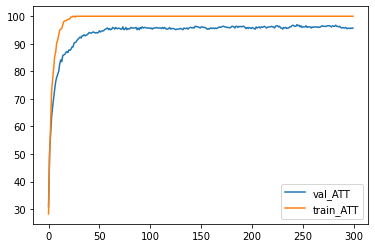

In [51]:
states[['val_ATT','train_ATT']].plot()

<AxesSubplot:>

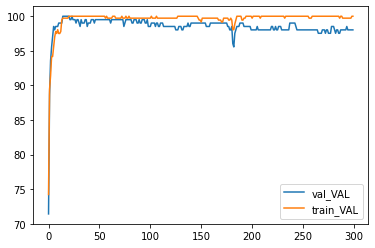

In [52]:
states[['val_VAL','train_VAL']].plot()

<AxesSubplot:>

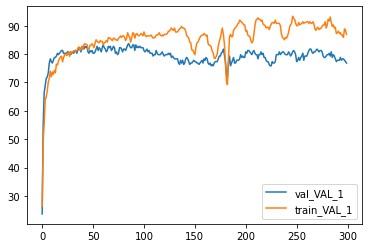

In [53]:
states[['val_VAL_1','train_VAL_1']].plot()

<AxesSubplot:>

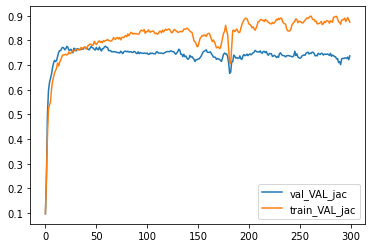

In [54]:
states[['val_VAL_jac','train_VAL_jac']].plot()

In [55]:
unlabel_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', ~(data['all'].train_mask + data['all'].val_mask + data['all'].test_mask)),
)

In [56]:
@torch.no_grad()
def predict(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch['all'].batch_size
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict
        
        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch['all'].n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [57]:
pred_train = predict(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.14it/s]


In [58]:
pred_val = predict(model, val_loader)
pred_test = predict(model, test_loader)
pred_unlab = predict(model, unlabel_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 50.20it/s]


In [59]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [60]:
preds[:,1:].sum(axis=1)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000])

In [61]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [62]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.012029,0.088683,0.011687,0.006054,0.118311,0.131774,0.054826,0.006914,0.569722,0.062617,0.313355,0.248413,0.226336,0.020531,0.110596,0.003042,0.002350,0.002812,0.002456,0.007490
1.0,0.004837,0.028246,0.002863,0.001764,0.034731,0.046041,0.005025,0.001421,0.875072,0.137637,0.398767,0.201193,0.121985,0.012093,0.108119,0.003789,0.002976,0.002760,0.002394,0.008287
2.0,0.036089,0.078575,0.031075,0.019435,0.185393,0.265998,0.122452,0.022095,0.238887,0.138922,0.255579,0.274190,0.166238,0.014719,0.129615,0.003438,0.002693,0.002419,0.003353,0.008832
3.0,0.051361,0.150938,0.045759,0.013143,0.010101,0.123450,0.538207,0.053582,0.013460,0.058045,0.042164,0.138819,0.068568,0.021752,0.636689,0.009049,0.003480,0.003555,0.005968,0.011910
4.0,0.180169,0.345325,0.006466,0.055198,0.008491,0.354537,0.034503,0.006942,0.008367,0.202020,0.097755,0.087355,0.212235,0.012933,0.368726,0.003895,0.002591,0.001858,0.002564,0.008069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.017616,0.439280,0.135162,0.017472,0.004883,0.022320,0.309937,0.038139,0.015191,0.340245,0.229997,0.144590,0.165742,0.018018,0.067797,0.006549,0.004812,0.004153,0.006711,0.011385
2947.0,0.002321,0.031558,0.256148,0.008119,0.001889,0.003627,0.648931,0.043604,0.003803,0.293560,0.207870,0.170516,0.201816,0.020935,0.074092,0.006173,0.003816,0.003362,0.006331,0.011528
2948.0,0.046939,0.525092,0.069220,0.015932,0.013705,0.025892,0.262478,0.031094,0.009648,0.323923,0.192555,0.196003,0.186708,0.020813,0.040270,0.007749,0.006391,0.005237,0.008875,0.011475


In [63]:
preds_df.to_csv(args.save_dir + 'preds.csv', sep='\t')

In [64]:
states.to_csv(args.save_dir + 'train_state.csv', sep='\t')

## Per-Class Metrics

In [65]:
from sklearn.metrics import confusion_matrix

In [66]:
preds = pd.read_csv(args.save_dir + 'preds.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.012029,0.088683,0.011687,0.006054,0.118311,0.131774,0.054826,0.006914,0.569722,0.062617,0.313355,0.248413,0.226336,0.020531,0.110596,0.003042,0.002350,0.002812,0.002456,0.007490
1.0,0.004837,0.028246,0.002863,0.001764,0.034731,0.046041,0.005025,0.001421,0.875072,0.137637,0.398767,0.201193,0.121985,0.012093,0.108119,0.003789,0.002976,0.002760,0.002394,0.008287
2.0,0.036089,0.078575,0.031075,0.019435,0.185393,0.265998,0.122452,0.022095,0.238887,0.138923,0.255579,0.274190,0.166238,0.014719,0.129615,0.003438,0.002693,0.002419,0.003353,0.008832
3.0,0.051361,0.150938,0.045759,0.013143,0.010101,0.123450,0.538207,0.053582,0.013460,0.058045,0.042164,0.138819,0.068568,0.021752,0.636689,0.009049,0.003480,0.003555,0.005968,0.011910
4.0,0.180170,0.345325,0.006466,0.055198,0.008491,0.354537,0.034503,0.006942,0.008367,0.202020,0.097755,0.087355,0.212235,0.012933,0.368726,0.003895,0.002591,0.001858,0.002564,0.008069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.017616,0.439280,0.135162,0.017472,0.004883,0.022320,0.309937,0.038139,0.015191,0.340245,0.229997,0.144590,0.165742,0.018018,0.067797,0.006549,0.004812,0.004153,0.006711,0.011385
2947.0,0.002321,0.031558,0.256148,0.008119,0.001889,0.003627,0.648931,0.043604,0.003803,0.293560,0.207870,0.170516,0.201816,0.020935,0.074092,0.006173,0.003816,0.003362,0.006331,0.011528
2948.0,0.046939,0.525092,0.069220,0.015932,0.013705,0.025892,0.262478,0.031094,0.009648,0.323923,0.192555,0.196003,0.186708,0.020813,0.040270,0.007749,0.006391,0.005237,0.008875,0.011475


In [67]:
pred = torch.tensor(np.array(preds)).to(device)

In [68]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [69]:
test_ATT_conf = confusion_matrix(data['all'].y[(data['all'].att_lab) * data['all'].test_mask][:,:9].argmax(axis=1).cpu(), 
                                 pred[(data['all'].att_lab) * data['all'].test_mask][:,:9].argmax(axis=1).cpu(), labels = range(9))
test_VAL_conf = confusion_matrix(data['all'].y[(data['all'].val_lab) * data['all'].test_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data['all'].val_lab) * data['all'].test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data['all'].y[(data['all'].val_lab) * data['all'].test_mask][:,9:].cpu(),  
                                 pred[(data['all'].val_lab) * data['all'].test_mask][:,9:].cpu(),3)).astype(int)

In [70]:
test_ATT_conf

array([[ 64,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1, 142,   0,   0,   0,   1,   1,   0,   0],
       [  0,   0,  10,   0,   0,   0,   0,   1,   0],
       [  1,   0,   0,  16,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,  70,   0,   2,   0,   0],
       [  0,   2,   0,   0,   0, 100,   0,   0,   0],
       [  0,   3,   0,   0,   3,   0,  71,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  12]], dtype=int64)

In [71]:
test_VAL_conf

array([[55,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5, 14,  3,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  6, 21,  2,  0,  4,  0,  0,  0,  0,  0],
       [ 1,  3,  2, 25,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  2,  3,  0, 35,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [72]:
test_VAL_conf_k

array([[ 91,  60,  41,  46,   0,  44,   0,   0,   0,   0,   0],
       [ 49,  87,  70,  59,   2,  42,   0,   0,   0,   0,   0],
       [ 55,  82, 106,  90,   1,  74,   0,   0,   0,   0,   0],
       [ 56,  80,  79, 118,   2,  64,   0,   0,   0,   0,   0],
       [  0,   3,   2,   3,   1,   0,   0,   0,   0,   0,   0],
       [ 45,  42,  70,  68,   0,  84,   0,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0,   2,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   1,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [73]:
val_ATT_conf = confusion_matrix(data['all'].y[(data['all'].att_lab) * data['all'].val_mask][:,:9].argmax(axis=1).cpu(), 
                                 pred[(data['all'].att_lab) * data['all'].val_mask][:,:9].argmax(axis=1).cpu(), labels = range(9))
val_VAL_conf = confusion_matrix(data['all'].y[(data['all'].val_lab) * data['all'].val_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data['all'].val_lab) * data['all'].val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data['all'].y[(data['all'].val_lab) * data['all'].val_mask][:,9:].cpu(),  
                                 pred[(data['all'].val_lab) * data['all'].val_mask][:,9:].cpu(),3)).astype(int)

In [74]:
val_ATT_conf

array([[ 61,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 144,   0,   0,   0,   1,   1,   0,   0],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0],
       [  1,   1,   0,  20,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,  73,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0, 103,   0,   0,   0],
       [  0,   2,   0,   0,   0,   0,  60,   0,   0],
       [  0,   0,   2,   0,   0,   0,   2,   1,   0],
       [  0,   1,   0,   0,   2,   0,   0,   0,   7]], dtype=int64)

In [75]:
val_VAL_conf

array([[64,  3,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 2,  9,  4,  3,  0,  1,  0,  0,  0,  0,  0],
       [ 2,  0, 21,  2,  0,  6,  0,  0,  0,  0,  0],
       [ 2,  1,  0, 30,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  4,  4,  1,  0, 37,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [76]:
val_VAL_conf_k

array([[106,  66,  50,  55,   0,  47,   0,   0,   0,   0,   0],
       [ 60,  85,  64,  69,   3,  40,   0,   0,   0,   0,   0],
       [ 57,  60, 111,  90,   0,  75,   0,   0,   0,   0,   0],
       [ 69,  82,  93, 118,   3,  61,   0,   0,   0,   0,   0],
       [  0,   8,   5,   8,   3,   0,   0,   0,   0,   0,   0],
       [ 53,  35,  91,  65,   0,  95,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [77]:
pd.concat([pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT.csv')
pd.concat([pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL.csv')
pd.concat([pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k.csv')

In [78]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [79]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [80]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [81]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [82]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [83]:
metrics_df.to_csv(args.save_dir+'per_class_metrics.csv')

## TEM links

In [29]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [3 *args.sample_nodes] * 2 for key in data.edge_types if 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [3* args.sample_nodes] * 2 for key in data.edge_types if 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [3* args.sample_nodes] * 2 for key in data.edge_types if 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [30]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=1027,
    x=[1027, 1753],
    y=[1027, 20],
    node_type=[1027],
    att_lab=[1027],
    val_lab=[1027],
    train_mask=[1027],
    val_mask=[1027],
    test_mask=[1027],
    n_id=[1027],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, SPA_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, TEM_link, all)={
    edge_index=[2, 51708],
    edge_attr=[51708]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [31]:
model

HGT_L(
  (lin_dict): ModuleDict(
    (all): Linear(1753, 32, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(-1, 32, heads=2)
    (1): HGTConv(-1, 32, heads=2)
    (2): HGTConv(-1, 32, heads=2)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [32]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.85it/s]


(0.7255107517717948,
 1.5993303985146605,
 100.0,
 100.0,
 0.8716528250570112,
 89.75069252077563)

In [33]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader,'val')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 11.07it/s]


(0.8410670141863629,
 1.6250746361727786,
 96.95121951219512,
 98.0295566502463,
 0.7348111721095193,
 79.3103448275862)

In [34]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader,'val')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.75it/s]


(0.8529867110385099,
 1.6444494693229597,
 96.22266401590457,
 99.47916666666667,
 0.7317708432674408,
 78.125)

In [35]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader,'val'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader,'val'))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 77.39it/s]


In [36]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [37]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,1.000000e+01
mean,8.410675e-01,1.625075e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
std,6.327162e-07,9.332467e-08,1.497956e-14,1.497956e-14,0.000000,1.497956e-14
min,8.410664e-01,1.625075e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
25%,8.410670e-01,1.625075e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
50%,8.410676e-01,1.625075e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
75%,8.410680e-01,1.625075e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
max,8.410685e-01,1.625075e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01


In [38]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,10.000000,1.000000e+01,10.000000,10.000
mean,8.529866e-01,1.644450e+00,96.222664,9.947917e+01,0.731771,78.125
std,5.912551e-07,3.124121e-07,0.000000,1.497956e-14,0.000000,0.000
min,8.529856e-01,1.644450e+00,96.222664,9.947917e+01,0.731771,78.125
25%,8.529863e-01,1.644450e+00,96.222664,9.947917e+01,0.731771,78.125
50%,8.529867e-01,1.644450e+00,96.222664,9.947917e+01,0.731771,78.125
75%,8.529870e-01,1.644450e+00,96.222664,9.947917e+01,0.731771,78.125
max,8.529872e-01,1.644451e+00,96.222664,9.947917e+01,0.731771,78.125


In [106]:
val_df.to_csv(args.save_dir + 'TEM_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'TEM_test_metrics_transfer.csv', sep='\t')

## SPA links

In [48]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [3*args.sample_nodes] * 2 for key in data.edge_types if 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [3*args.sample_nodes] * 2 for key in data.edge_types if 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [3*args.sample_nodes] * 2 for key in data.edge_types if 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [49]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2163,
    x=[2163, 1753],
    y=[2163, 20],
    node_type=[2163],
    att_lab=[2163],
    val_lab=[2163],
    train_mask=[2163],
    val_mask=[2163],
    test_mask=[2163],
    n_id=[2163],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, SPA_link, all)={
    edge_index=[2, 67657],
    edge_attr=[67657]
  },
  (all, TEM_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [50]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.16it/s]


(0.7255342998993364,
 1.599371404528948,
 100.0,
 100.0,
 0.8702677835057647,
 90.02770083102493)

In [51]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader, 'val')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 37.33it/s]


(0.841040769243628,
 1.6250538796626877,
 96.95121951219512,
 98.0295566502463,
 0.7348111721095193,
 79.3103448275862)

In [52]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader, 'val')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 38.18it/s]


(0.8529594320189171,
 1.6444498679290216,
 96.22266401590457,
 99.47916666666667,
 0.7317708432674408,
 78.64583333333333)

In [112]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader, 'val'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader, 'val'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 58.59it/s]


In [113]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [114]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.000000
mean,0.841042,1.625054e+00,9.695122e+01,9.802956e+01,0.735796,79.359606
std,0.000001,7.171497e-07,1.497956e-14,1.497956e-14,0.001272,0.155777
min,0.841039,1.625053e+00,9.695122e+01,9.802956e+01,0.734811,79.310345
25%,0.841041,1.625054e+00,9.695122e+01,9.802956e+01,0.734811,79.310345
50%,0.841042,1.625054e+00,9.695122e+01,9.802956e+01,0.734811,79.310345
75%,0.841042,1.625055e+00,9.695122e+01,9.802956e+01,0.737274,79.310345
max,0.841044,1.625056e+00,9.695122e+01,9.802956e+01,0.737274,79.802956


In [115]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,1.000000e+01,10.000000,1.000000e+01,10.000000,1.000000e+01
mean,0.852962,1.644450e+00,96.222664,9.947917e+01,0.731944,7.864583e+01
std,0.000002,8.763981e-07,0.000000,1.497956e-14,0.000366,1.497956e-14
min,0.852958,1.644448e+00,96.222664,9.947917e+01,0.731771,7.864583e+01
25%,0.852960,1.644449e+00,96.222664,9.947917e+01,0.731771,7.864583e+01
50%,0.852962,1.644450e+00,96.222664,9.947917e+01,0.731771,7.864583e+01
75%,0.852962,1.644450e+00,96.222664,9.947917e+01,0.731771,7.864583e+01
max,0.852964,1.644451e+00,96.222664,9.947917e+01,0.732639,7.864583e+01


In [116]:
val_df.to_csv(args.save_dir + 'SPA_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SPA_test_metrics_transfer.csv', sep='\t')

## SOC links

In [53]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [3*args.sample_nodes] * 2 for key in data.edge_types if 'SOC_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [3*args.sample_nodes] * 2 for key in data.edge_types if 'SOC_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [3*args.sample_nodes] * 2 for key in data.edge_types if 'SOC_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [54]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=1761,
    x=[1761, 1753],
    y=[1761, 20],
    node_type=[1761],
    att_lab=[1761],
    val_lab=[1761],
    train_mask=[1761],
    val_mask=[1761],
    test_mask=[1761],
    n_id=[1761],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 47162],
    edge_attr=[47162]
  },
  (all, SPA_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, TEM_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [55]:
model

HGT_L(
  (lin_dict): ModuleDict(
    (all): Linear(1753, 32, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(-1, 32, heads=2)
    (1): HGTConv(-1, 32, heads=2)
    (2): HGTConv(-1, 32, heads=2)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [56]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.44it/s]


(0.7255760066396972,
 1.599351929825759,
 100.0,
 100.0,
 0.8702677835057647,
 90.02770083102493)

In [57]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader, 'val')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 41.24it/s]


(0.8410872680142643,
 1.6250287664347682,
 96.95121951219512,
 98.0295566502463,
 0.7348111721095193,
 79.80295566502463)

In [58]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader, 'val')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.69it/s]


(0.8530556848698535,
 1.6444088034331799,
 96.22266401590457,
 99.47916666666667,
 0.7317708432674408,
 78.125)

In [123]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader, 'val'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader, 'val'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 57.16it/s]


In [124]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [125]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,1.000000e+01
mean,8.410878e-01,1.625029e+00,9.695122e+01,9.802956e+01,0.734811,7.980296e+01
std,6.125743e-07,5.314976e-07,1.497956e-14,1.497956e-14,0.000000,1.497956e-14
min,8.410868e-01,1.625029e+00,9.695122e+01,9.802956e+01,0.734811,7.980296e+01
25%,8.410873e-01,1.625029e+00,9.695122e+01,9.802956e+01,0.734811,7.980296e+01
50%,8.410881e-01,1.625029e+00,9.695122e+01,9.802956e+01,0.734811,7.980296e+01
75%,8.410883e-01,1.625030e+00,9.695122e+01,9.802956e+01,0.734811,7.980296e+01
max,8.410884e-01,1.625030e+00,9.695122e+01,9.802956e+01,0.734811,7.980296e+01


In [126]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,10.000000,1.000000e+01,10.000000,10.000
mean,8.530563e-01,1.644410e+00,96.222664,9.947917e+01,0.731771,78.125
std,7.405013e-07,7.480199e-07,0.000000,1.497956e-14,0.000000,0.000
min,8.530550e-01,1.644408e+00,96.222664,9.947917e+01,0.731771,78.125
25%,8.530559e-01,1.644410e+00,96.222664,9.947917e+01,0.731771,78.125
50%,8.530565e-01,1.644410e+00,96.222664,9.947917e+01,0.731771,78.125
75%,8.530566e-01,1.644410e+00,96.222664,9.947917e+01,0.731771,78.125
max,8.530573e-01,1.644411e+00,96.222664,9.947917e+01,0.731771,78.125


In [127]:
val_df.to_csv(args.save_dir + 'SOC_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SOC_test_metrics_transfer.csv', sep='\t')

## NO TEM links

In [128]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [129]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2943,
    x=[2943, 1753],
    y=[2943, 20],
    node_type=[2943],
    att_lab=[2943],
    val_lab=[2943],
    train_mask=[2943],
    val_mask=[2943],
    test_mask=[2943],
    n_id=[2943],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 63929],
    edge_attr=[63929]
  },
  (all, SPA_link, all)={
    edge_index=[2, 68216],
    edge_attr=[68216]
  },
  (all, TEM_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [130]:
model

HGT_L(
  (lin_dict): ModuleDict(
    (all): Linear(1753, 32, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(-1, 32, heads=2)
    (1): HGTConv(-1, 32, heads=2)
    (2): HGTConv(-1, 32, heads=2)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [131]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.08it/s]


(0.7254844600143855,
 1.5993549268991993,
 100.0,
 100.0,
 0.872576187852347,
 90.02770083102493)

In [132]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader, 'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 37.05it/s]


(0.8409768699145899,
 1.6250564453049834,
 96.95121951219512,
 98.0295566502463,
 0.7348111721095193,
 79.3103448275862)

In [133]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader, 'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 37.82it/s]


(0.85284924305694,
 1.6444347966462374,
 96.22266401590457,
 99.47916666666667,
 0.7343750099341074,
 78.64583333333333)

In [134]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader, 'val'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader, 'val'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.11it/s]


In [135]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [136]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,1.000000e+01
mean,0.840975,1.625058e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
std,0.000002,8.522315e-07,1.497956e-14,1.497956e-14,0.000000,1.497956e-14
min,0.840972,1.625056e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
25%,0.840973,1.625057e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
50%,0.840975,1.625057e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
75%,0.840976,1.625058e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01
max,0.840978,1.625059e+00,9.695122e+01,9.802956e+01,0.734811,7.931034e+01


In [137]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,1.000000e+01,10.000000,1.000000e+01,10.000000,1.000000e+01
mean,0.852848,1.644436e+00,96.222664,9.947917e+01,0.734635,7.864583e+01
std,0.000002,7.253492e-07,0.000000,1.497956e-14,0.000824,1.497956e-14
min,0.852845,1.644435e+00,96.222664,9.947917e+01,0.734375,7.864583e+01
25%,0.852846,1.644435e+00,96.222664,9.947917e+01,0.734375,7.864583e+01
50%,0.852846,1.644436e+00,96.222664,9.947917e+01,0.734375,7.864583e+01
75%,0.852850,1.644436e+00,96.222664,9.947917e+01,0.734375,7.864583e+01
max,0.852851,1.644437e+00,96.222664,9.947917e+01,0.736979,7.864583e+01


In [138]:
val_df.to_csv(args.save_dir + 'NO_TEM_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'NO_TEM_test_metrics_transfer.csv', sep='\t')

## NO SPA links

In [139]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [140]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2946,
    x=[2946, 1753],
    y=[2946, 20],
    node_type=[2946],
    att_lab=[2946],
    val_lab=[2946],
    train_mask=[2946],
    val_mask=[2946],
    test_mask=[2946],
    n_id=[2946],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 53785],
    edge_attr=[53785]
  },
  (all, SPA_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, TEM_link, all)={
    edge_index=[2, 54310],
    edge_attr=[54310]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [141]:
model

HGT_L(
  (lin_dict): ModuleDict(
    (all): Linear(1753, 32, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(-1, 32, heads=2)
    (1): HGTConv(-1, 32, heads=2)
    (2): HGTConv(-1, 32, heads=2)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [142]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.01it/s]


(0.7254592820878174,
 1.599312377108101,
 100.0,
 100.0,
 0.8711911463011005,
 89.75069252077563)

In [143]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader, 'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 41.09it/s]


(0.8410046713623575,
 1.6250814951112118,
 96.95121951219512,
 98.0295566502463,
 0.7372742262967115,
 79.3103448275862)

In [144]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader, 'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.80it/s]


(0.852870823611796,
 1.6444365698844194,
 96.42147117296223,
 99.47916666666667,
 0.7369791766007742,
 78.64583333333333)

In [145]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader, 'val'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader, 'val'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.53it/s]


In [146]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [147]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,1.000000e+01
mean,0.841006,1.625080,9.695122e+01,9.802956e+01,0.737274,7.931034e+01
std,0.000002,0.000001,1.497956e-14,1.497956e-14,0.000000,1.497956e-14
min,0.841002,1.625078,9.695122e+01,9.802956e+01,0.737274,7.931034e+01
25%,0.841005,1.625079,9.695122e+01,9.802956e+01,0.737274,7.931034e+01
50%,0.841005,1.625080,9.695122e+01,9.802956e+01,0.737274,7.931034e+01
75%,0.841007,1.625081,9.695122e+01,9.802956e+01,0.737274,7.931034e+01
max,0.841010,1.625082,9.695122e+01,9.802956e+01,0.737274,7.931034e+01


In [148]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,1.000000e+01,1.000000e+01
mean,0.852874,1.644435,96.322068,9.947917e+01,7.369792e-01,7.864583e+01
std,0.000001,0.000001,0.104781,1.497956e-14,1.170278e-16,1.497956e-14
min,0.852872,1.644433,96.222664,9.947917e+01,7.369792e-01,7.864583e+01
25%,0.852873,1.644435,96.222664,9.947917e+01,7.369792e-01,7.864583e+01
50%,0.852874,1.644436,96.322068,9.947917e+01,7.369792e-01,7.864583e+01
75%,0.852875,1.644436,96.421471,9.947917e+01,7.369792e-01,7.864583e+01
max,0.852876,1.644438,96.421471,9.947917e+01,7.369792e-01,7.864583e+01


In [149]:
val_df.to_csv(args.save_dir + 'NO_SPA_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'NO_SPA_test_metrics_transfer.csv', sep='\t')

## NO SOC links

In [150]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'TEM_link' in key or 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'TEM_link' in key or 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'TEM_link' in key or 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [151]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2929,
    x=[2929, 1753],
    y=[2929, 20],
    node_type=[2929],
    att_lab=[2929],
    val_lab=[2929],
    train_mask=[2929],
    val_mask=[2929],
    test_mask=[2929],
    n_id=[2929],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, SPA_link, all)={
    edge_index=[2, 23343],
    edge_attr=[23343]
  },
  (all, TEM_link, all)={
    edge_index=[2, 22314],
    edge_attr=[22314]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [152]:
model

HGT_L(
  (lin_dict): ModuleDict(
    (all): Linear(1753, 32, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(-1, 32, heads=2)
    (1): HGTConv(-1, 32, heads=2)
    (2): HGTConv(-1, 32, heads=2)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [153]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.01it/s]


(0.7254116338706083,
 1.5993375355517105,
 100.0,
 100.0,
 0.8711911463011005,
 90.02770083102493)

In [154]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader, 'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 67.37it/s]


(0.8409538775440154,
 1.6251165326592958,
 96.95121951219512,
 98.0295566502463,
 0.7372742262967115,
 79.3103448275862)

In [155]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader, 'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 65.23it/s]


(0.8527654360824266,
 1.644487414509058,
 96.42147117296223,
 99.47916666666667,
 0.7369791766007742,
 78.125)

In [156]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader, 'val'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader, 'val'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 70.35it/s]


In [157]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [158]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,1.000000e+01
mean,0.840953,1.625117,9.695122e+01,9.802956e+01,0.737356,7.931034e+01
std,0.000004,0.000002,1.497956e-14,1.497956e-14,0.000260,1.497956e-14
min,0.840947,1.625114,9.695122e+01,9.802956e+01,0.737274,7.931034e+01
25%,0.840950,1.625117,9.695122e+01,9.802956e+01,0.737274,7.931034e+01
50%,0.840953,1.625117,9.695122e+01,9.802956e+01,0.737274,7.931034e+01
75%,0.840955,1.625118,9.695122e+01,9.802956e+01,0.737274,7.931034e+01
max,0.840958,1.625120,9.695122e+01,9.802956e+01,0.738095,7.931034e+01


In [159]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.852765,1.644489,96.421471,9.947917e+01,0.737760,78.177083
std,0.000002,0.000002,0.000000,1.497956e-14,0.001258,0.164702
min,0.852763,1.644487,96.421471,9.947917e+01,0.736979,78.125000
25%,0.852764,1.644488,96.421471,9.947917e+01,0.736979,78.125000
50%,0.852766,1.644489,96.421471,9.947917e+01,0.736979,78.125000
75%,0.852767,1.644491,96.421471,9.947917e+01,0.738932,78.125000
max,0.852769,1.644493,96.421471,9.947917e+01,0.739583,78.645833


In [160]:
val_df.to_csv(args.save_dir + 'NO_SOC_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'NO_SOC_test_metrics_transfer.csv', sep='\t')

## Masking Visual and Textual Features

In [27]:
model = HGT_L(data.metadata(), hidden_channels=32, out_channels=data.y_dict['all'].shape[-1],
                  num_layers=3, num_heads = 2, group='mean').to(device)

In [28]:
model.load_state_dict(torch.load(args.save_dir+'HGT_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [29]:
model

HGT_L(
  (lin_dict): ModuleDict(
    (all): Linear(1753, 32, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(-1, 32, heads=2)
    (1): HGTConv(-1, 32, heads=2)
    (2): HGTConv(-1, 32, heads=2)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [30]:
@torch.no_grad()
def test_Mask(model, loader, mask='vis'):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    running_1_val = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch['all'].batch_size
        
        if mask == 'vis':
            batch['all'].x[:batch_size,:982] = torch.zeros(batch_size,982)
        elif mask == 'tex':
            batch['all'].x[:batch_size,982:] = torch.zeros(batch_size,771)
                
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict

        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch['all'].att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch['all'].val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y_dict['all']
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]

    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val

In [31]:
test_Mask(model, train_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.40it/s]


(1.9956734160637262,
 1.6647645836061389,
 23.822714681440445,
 99.7229916897507,
 0.6980609523952833,
 77.5623268698061)

In [32]:
test_Mask(model, train_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.61it/s]


(0.7889452987760718,
 1.92601609692349,
 100.0,
 77.5623268698061,
 0.05632502311154416,
 32.40997229916898)

In [33]:
test_Mask(model, val_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 41.12it/s]


(2.1549280154995802,
 1.6708702688733932,
 17.276422764227643,
 99.01477832512315,
 0.7068965540730895,
 77.33990147783251)

In [34]:
test_Mask(model, val_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.56it/s]


(0.8652394693799135,
 1.968609806939299,
 96.7479674796748,
 59.60591133004926,
 0.04433497536945813,
 21.67487684729064)

In [35]:
test_Mask(model, test_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.84it/s]


(2.146076456926926,
 1.6830203402787447,
 14.115308151093439,
 98.4375,
 0.7031250074505806,
 76.04166666666667)

In [36]:
test_Mask(model, test_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.71it/s]


(0.8747231437719128,
 1.9744189474731684,
 97.4155069582505,
 62.5,
 0.01996527782951792,
 22.395833333333332)

In [37]:
val_numbers_vis = []
val_numbers_tex = []
test_numbers_vis = []
test_numbers_tex = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers_vis.append(test_Mask(model, val_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    val_numbers_tex.append(test_Mask(model, val_loader, 'tex'))
    
    set_seed_everywhere(seed, args.cuda)
    test_numbers_vis.append(test_Mask(model, test_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers_tex.append(test_Mask(model, test_loader, 'tex'))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 52.33it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.46it/s]


In [38]:
val_df_vis = pd.DataFrame(val_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
val_df_tex = pd.DataFrame(val_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_vis = pd.DataFrame(test_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_tex = pd.DataFrame(test_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [39]:
val_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,1.000000e+01,1.000000e+01
mean,2.154920,1.670870,17.276423,9.901478e+01,7.068966e-01,7.733990e+01
std,0.000011,0.000002,0.000000,1.497956e-14,1.170278e-16,1.497956e-14
min,2.154904,1.670866,17.276423,9.901478e+01,7.068966e-01,7.733990e+01
25%,2.154912,1.670868,17.276423,9.901478e+01,7.068966e-01,7.733990e+01
50%,2.154920,1.670871,17.276423,9.901478e+01,7.068966e-01,7.733990e+01
75%,2.154927,1.670871,17.276423,9.901478e+01,7.068966e-01,7.733990e+01
max,2.154939,1.670873,17.276423,9.901478e+01,7.068966e-01,7.733990e+01


In [40]:
val_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,1.000000e+01
mean,0.865238,1.968593,96.747967,5.960591e+01,0.044335,2.167488e+01
std,0.000005,0.000008,0.000000,7.489778e-15,0.000000,3.744889e-15
min,0.865229,1.968580,96.747967,5.960591e+01,0.044335,2.167488e+01
25%,0.865236,1.968587,96.747967,5.960591e+01,0.044335,2.167488e+01
50%,0.865237,1.968594,96.747967,5.960591e+01,0.044335,2.167488e+01
75%,0.865240,1.968600,96.747967,5.960591e+01,0.044335,2.167488e+01
max,0.865245,1.968604,96.747967,5.960591e+01,0.044335,2.167488e+01


In [41]:
test_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.0000,10.000000,1.000000e+01
mean,2.146078,1.683017,14.234592,98.4375,0.703125,7.604167e+01
std,0.000004,0.000002,0.102664,0.0000,0.000000,1.497956e-14
min,2.146073,1.683013,14.115308,98.4375,0.703125,7.604167e+01
25%,2.146076,1.683016,14.115308,98.4375,0.703125,7.604167e+01
50%,2.146077,1.683018,14.314115,98.4375,0.703125,7.604167e+01
75%,2.146081,1.683019,14.314115,98.4375,0.703125,7.604167e+01
max,2.146086,1.683020,14.314115,98.4375,0.703125,7.604167e+01


In [42]:
test_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.0,1.000000e+01,1.000000e+01
mean,0.874717,1.974425,97.415507,62.5,1.996528e-02,2.239583e+01
std,0.000003,0.000008,0.000000,0.0,3.657118e-18,3.744889e-15
min,0.874713,1.974413,97.415507,62.5,1.996528e-02,2.239583e+01
25%,0.874715,1.974419,97.415507,62.5,1.996528e-02,2.239583e+01
50%,0.874715,1.974427,97.415507,62.5,1.996528e-02,2.239583e+01
75%,0.874718,1.974430,97.415507,62.5,1.996528e-02,2.239583e+01
max,0.874722,1.974439,97.415507,62.5,1.996528e-02,2.239583e+01


In [43]:
val_df_vis.to_csv(args.save_dir + 'vis_masked_val_metrics.csv', sep='\t')
val_df_tex.to_csv(args.save_dir + 'tex_masked_val_metrics.csv', sep='\t')
test_df_vis.to_csv(args.save_dir + 'vis_masked_test_metrics.csv', sep='\t')
test_df_tex.to_csv(args.save_dir + 'tex_masked_test_metrics.csv', sep='\t')

## Direct Prediction on VEN-XL

In [19]:
device = torch.device("cpu")
#device = torch.device("cpu")
print(device)

cpu


In [12]:
dataset_XL = VEN_XL_Links('dataset/Venice_XL_links')
data_XL = dataset_XL[0].to(device)

In [20]:
data_XL = VEN_XL_Links('dataset/Venice_XL_links')[0].to(device)

In [21]:
data_XL['all'].n_id = torch.arange(data_XL.num_nodes)
#data_XL = data_XL.to(device)
data_XL

HeteroData(
  all={
    num_nodes=80963,
    x=[80963, 1753],
    y=[80963, 20],
    node_type=[80963],
    att_lab=[80963],
    val_lab=[80963],
    train_mask=[80963],
    val_mask=[80963],
    test_mask=[80963],
    n_id=[80963]
  },
  (all, SOC_link, all)={
    edge_index=[2, 76422265],
    edge_attr=[76422265]
  },
  (all, SPA_link, all)={
    edge_index=[2, 202173159],
    edge_attr=[202173159]
  },
  (all, TEM_link, all)={
    edge_index=[2, 71135671],
    edge_attr=[71135671]
  },
  (all, simp_link, all)={
    edge_index=[2, 290091503],
    edge_attr=[290091503]
  }
)

In [22]:
model = HGT_L(data_XL.metadata(), hidden_channels=32, out_channels=data_XL.y_dict['all'].shape[-1],
                  num_layers=3, num_heads = 2, group='mean').to(device)

In [23]:
model.load_state_dict(torch.load(args.save_dir+'HGT_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [24]:
model

HGT_L(
  (lin_dict): ModuleDict(
    (all): Linear(1753, 32, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(-1, 32, heads=2)
    (1): HGTConv(-1, 32, heads=2)
    (2): HGTConv(-1, 32, heads=2)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [25]:
from torch_geometric.loader import NeighborLoader

In [26]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data_XL.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data_XL['all'].train_mask),
)

In [29]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data_XL.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data_XL['all'].val_mask),
)

In [28]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data_XL.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data_XL['all'].test_mask),
)

In [26]:
seed_everything(args.seed)
unlabel_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data_XL.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', ~(data_XL['all'].train_mask + data_XL['all'].val_mask + data_XL['all'].test_mask)),
)

In [27]:
@torch.no_grad()
def predict(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch['all'].batch_size
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict
        
        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch['all'].n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [28]:
pred_train = predict(model, train_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [08:21<00:00,  1.39s/it]


In [31]:
pred_val = predict(model, val_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [13:51<00:00,  1.33s/it]


In [30]:
pred_test = predict(model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [13:43<00:00,  1.32s/it]


In [28]:
pred_unlab = predict(model, unlabel_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 921/921 [19:17<00:00,  1.26s/it]


In [33]:
pred_train[0]

tensor([4.0000e+00, 3.6224e-03, 9.1489e-01, 3.9630e-03, 1.8197e-03, 1.3219e-03,
        5.5136e-02, 7.6846e-03, 1.3151e-03, 1.0246e-02, 1.7893e-02, 1.2161e-01,
        1.6164e-01, 4.4398e-01, 1.1871e-01, 9.0284e-02, 8.5269e-03, 4.6221e-03,
        1.1879e-02, 5.8970e-03, 1.4952e-02])

In [31]:
preds = torch.vstack([pred, pred_unlab]).cpu()

In [34]:
preds = torch.vstack([pred_train, pred_val, pred_test]).cpu()

In [35]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [35]:
preds

tensor([[4.0000e+00, 2.6310e-03, 9.3372e-01,  ..., 7.3632e-03, 4.8628e-03,
         1.2648e-02],
        [5.0000e+00, 7.4130e-03, 9.0296e-01,  ..., 6.7272e-03, 5.7115e-03,
         1.2796e-02],
        [8.0000e+00, 3.3455e-03, 8.2061e-01,  ..., 4.6515e-03, 7.1458e-03,
         8.4681e-03],
        ...,
        [8.0955e+04, 2.2351e-02, 5.4676e-01,  ..., 6.5204e-03, 5.7883e-03,
         1.2591e-02],
        [8.0960e+04, 7.2552e-01, 1.0158e-01,  ..., 1.8194e-03, 2.8158e-03,
         7.7784e-03],
        [8.0962e+04, 5.5097e-01, 1.5797e-01,  ..., 2.8654e-03, 3.3919e-03,
         1.0750e-02]], dtype=torch.float64)

In [37]:
preds[:,1:].sum(axis=1)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000])

In [32]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [33]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.590949,0.045722,0.019597,0.036334,0.006759,0.234161,0.023612,0.017325,0.025541,0.254323,0.110100,0.157668,0.360964,0.027947,0.065056,0.004690,0.003224,0.003101,0.004269,0.008657
1.0,0.224058,0.007389,0.000600,0.003432,0.000876,0.756404,0.000719,0.000756,0.005767,0.172469,0.098551,0.113473,0.485997,0.025722,0.089703,0.002135,0.001354,0.001644,0.001947,0.007005
2.0,0.010895,0.313081,0.016462,0.013692,0.455680,0.016656,0.087140,0.008610,0.077785,0.113593,0.104693,0.133691,0.131544,0.041658,0.372583,0.028839,0.018939,0.016940,0.014645,0.022876
3.0,0.009238,0.242052,0.035775,0.020205,0.033555,0.094468,0.470154,0.029190,0.065364,0.042914,0.174083,0.210648,0.218459,0.088202,0.200309,0.015257,0.010063,0.014033,0.008566,0.017468
4.0,0.002631,0.933718,0.005695,0.001904,0.001124,0.033052,0.008198,0.001211,0.012467,0.016775,0.144019,0.176092,0.419996,0.137657,0.071999,0.005330,0.003258,0.007363,0.004863,0.012648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.044957,0.352496,0.012269,0.015928,0.008300,0.409278,0.056828,0.011234,0.088709,0.093243,0.331395,0.165370,0.290632,0.013885,0.087260,0.002615,0.002840,0.002756,0.002504,0.007499
80959.0,0.886580,0.029885,0.001693,0.043460,0.012236,0.008936,0.009009,0.006306,0.001894,0.235541,0.250493,0.204294,0.184092,0.009316,0.095288,0.002649,0.003574,0.002417,0.002847,0.009487
80960.0,0.725524,0.101577,0.002193,0.055688,0.010050,0.079787,0.013755,0.007198,0.004228,0.270172,0.137503,0.240337,0.161904,0.004919,0.165948,0.002785,0.004019,0.001819,0.002816,0.007778


In [34]:
preds_df.to_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t')

## Evaluation Metrics

In [35]:
preds = pd.read_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.590949,0.045722,0.019597,0.036334,0.006759,0.234161,0.023612,0.017325,0.025541,0.254323,0.110100,0.157668,0.360964,0.027947,0.065056,0.004690,0.003224,0.003101,0.004269,0.008657
1.0,0.224058,0.007389,0.000600,0.003432,0.000876,0.756404,0.000719,0.000756,0.005767,0.172469,0.098551,0.113473,0.485997,0.025722,0.089703,0.002135,0.001354,0.001644,0.001947,0.007005
2.0,0.010895,0.313081,0.016462,0.013692,0.455680,0.016656,0.087140,0.008610,0.077785,0.113593,0.104693,0.133691,0.131544,0.041658,0.372583,0.028839,0.018939,0.016940,0.014645,0.022876
3.0,0.009238,0.242052,0.035775,0.020205,0.033555,0.094468,0.470154,0.029190,0.065364,0.042914,0.174083,0.210648,0.218459,0.088202,0.200309,0.015257,0.010063,0.014033,0.008566,0.017468
4.0,0.002631,0.933718,0.005695,0.001904,0.001124,0.033052,0.008198,0.001211,0.012467,0.016775,0.144019,0.176092,0.419996,0.137657,0.071999,0.005330,0.003258,0.007363,0.004863,0.012648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.044957,0.352496,0.012269,0.015928,0.008300,0.409278,0.056828,0.011234,0.088709,0.093243,0.331395,0.165370,0.290632,0.013885,0.087260,0.002615,0.002840,0.002756,0.002504,0.007499
80959.0,0.886580,0.029885,0.001693,0.043460,0.012236,0.008936,0.009009,0.006306,0.001894,0.235541,0.250493,0.204294,0.184092,0.009316,0.095288,0.002649,0.003574,0.002417,0.002847,0.009487
80960.0,0.725524,0.101577,0.002193,0.055688,0.010050,0.079787,0.013755,0.007198,0.004228,0.270172,0.137503,0.240337,0.161904,0.004919,0.165948,0.002785,0.004019,0.001819,0.002816,0.007778


In [30]:
pred = torch.tensor(np.array(preds.reset_index())).to(device)

In [36]:
pred = torch.tensor(np.array(preds)).to(device)

In [37]:
eval_df = pd.DataFrame(('val_ATT_loss', 'val_VAL_loss', 'val_ATT_acc', 'val_VAL_acc', 'val_VAL_acc_k', 'val_VAL_jac_k'), columns=['name'])

In [38]:
train_ATT_loss = F.cross_entropy(data_XL['all'].y[data_XL['all'].train_mask][:,:9], 
                pred[data_XL['all'].train_mask][:,:9]).cpu().detach().item()
train_VAL_loss = F.cross_entropy(data_XL['all'].y[data_XL['all'].train_mask][:,9:], 
                pred[data_XL['all'].train_mask][:,9:]).cpu().detach().item()

train_ATT_acc = compute_1_accuracy(data_XL['all'].y[data_XL['all'].train_mask][:,:9], 
                pred[data_XL['all'].train_mask][:,:9])
train_VAL_acc = compute_1_accuracy(data_XL['all'].y[data_XL['all'].train_mask][:,9:], 
                pred[data_XL['all'].train_mask][:,9:])
train_VAL_acc_k = compute_k_accuracy(data_XL['all'].y[data_XL['all'].train_mask][:,9:].cpu(),  
                pred[data_XL['all'].train_mask][:,9:].cpu(),3)
train_VAL_jac_k = compute_jaccard_index(data_XL['all'].y[data_XL['all'].train_mask][:,9:].cpu(),  
                pred[data_XL['all'].train_mask][:,9:].cpu(),3)

In [39]:
eval_df['train'] = pd.DataFrame((train_ATT_loss, train_VAL_loss, train_ATT_acc, train_VAL_acc, train_VAL_acc_k, train_VAL_jac_k))

In [40]:
val_ATT_loss = F.cross_entropy(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9], 
                pred[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9]).cpu().detach().item()
val_VAL_loss = F.cross_entropy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:], 
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:]).cpu().detach().item()

val_ATT_acc = compute_1_accuracy(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9], 
                pred[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9])
val_VAL_acc = compute_1_accuracy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:], 
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:])
val_VAL_acc_k = compute_k_accuracy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),3)
val_VAL_jac_k = compute_jaccard_index(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),3)

In [41]:
eval_df['val'] = pd.DataFrame((val_ATT_loss, val_VAL_loss, val_ATT_acc, val_VAL_acc, val_VAL_acc_k, val_VAL_jac_k))

In [42]:
test_ATT_loss = F.cross_entropy(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9], 
                pred[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9]).cpu().detach().item()
test_VAL_loss = F.cross_entropy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:], 
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:]).cpu().detach().item()

test_ATT_acc = compute_1_accuracy(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9], 
                pred[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9])
test_VAL_acc = compute_1_accuracy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:], 
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:])
test_VAL_acc_k = compute_k_accuracy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),3)
test_VAL_jac_k = compute_jaccard_index(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),3)

In [43]:
eval_df['test'] = pd.DataFrame((test_ATT_loss, test_VAL_loss, test_ATT_acc, test_VAL_acc, test_VAL_acc_k, test_VAL_jac_k))

In [44]:
eval_df

,name,train,val,test
0,val_ATT_loss,1.758587,1.778306,1.780264
1,val_VAL_loss,2.245272,2.243987,2.243471
2,val_ATT_acc,91.356211,95.399798,95.253288
3,val_VAL_acc,77.578010,78.341794,78.917018
4,val_VAL_acc_k,97.951422,98.040045,98.199719
5,val_VAL_jac_k,0.726554,0.724760,0.723887


In [45]:
eval_df.to_csv(args.save_dir+'eval_metrics_XL_trans.csv')

## Per-Class Metrics

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [52]:
test_ATT_conf = confusion_matrix(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9].argmax(axis=1).cpu())
test_VAL_conf = confusion_matrix(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),3)).astype(int)

In [53]:
test_ATT_conf

array([[1348,    7,    0,   11,    1,   15,    6,    1,    0],
       [   5, 3151,    0,    6,    0,   11,   38,    0,    0],
       [   0,    0,  252,    0,    0,    0,   13,    0,    0],
       [  31,    5,    0,  586,    0,    1,   13,    1,    0],
       [   7,   20,    0,    3, 2636,    0,   35,    0,    3],
       [  16,   27,    0,    2,    1, 1533,    4,    0,    0],
       [   2,   32,    0,    1,   10,    0, 2548,    0,    0],
       [  12,    3,  107,   15,    0,    0,  135,   41,    0],
       [   0,    5,    0,    0,    4,    1,    0,    0,  146]],
      dtype=int64)

In [54]:
test_VAL_conf

array([[ 582,   15,   25,    6,    0,   52,    0,    0,    0,    0,    0],
       [  41,  518,  135,   29,    0,  126,    0,    0,    0,    0,    0],
       [  27,   76, 1119,   36,    0,  349,    0,    0,    0,    0,    0],
       [  29,   25,   72,  323,    0,   87,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  33,   22,  272,   23,    0, 3065,    0,    0,    0,    0,    0],
       [   1,    0,    2,    0,    0,    6,    1,    0,    0,    2,    0],
       [   0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    2,    0,    0,    3,    1,    0,    0,    3,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [55]:
test_VAL_conf_k

array([[1360,  827, 1151,  703,    0,  909,    3,    0,    0,    0,    0],
       [ 888, 1790, 2244, 1552,    4, 1730,    0,    0,    0,    0,    0],
       [ 952, 1892, 5786, 4237,    5, 5208,    4,    0,    0,    0,    0],
       [ 844, 1652, 4763, 4243,    5, 4296,    1,    0,    0,    0,    0],
       [   0,    8,   17,   16,    3,   10,    0,    0,    0,    0,    0],
       [ 834, 1379, 5289, 3894,    1, 5270,    4,    0,    0,    0,    0],
       [   9,    2,   25,    8,    0,   22,   13,    1,    3,   13,    0],
       [   3,    0,    3,    0,    0,    6,    5,    0,    1,    3,    0],
       [   1,    0,   11,    1,    0,    7,    9,    1,    2,   10,    0],
       [   2,    1,   13,    1,    0,   11,   12,    1,    3,   13,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [56]:
val_ATT_conf = confusion_matrix(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),3)).astype(int)

In [57]:
val_ATT_conf

array([[1322,    3,    0,    9,    1,    7,   10,    0,    0],
       [   7, 3237,    0,    3,    0,    8,   44,    0,    0],
       [   0,    0,  269,    0,    0,    0,   11,    0,    0],
       [  32,    7,    0,  629,    0,    0,   10,    2,    0],
       [   5,   34,    0,    3, 2604,    3,   36,    0,    2],
       [  18,   28,    0,    1,    3, 1436,    2,    0,    0],
       [   0,   24,    1,    1,   15,    0, 2589,    0,    0],
       [  13,    4,   84,    7,    0,    0,  138,   40,    0],
       [   0,   10,    0,    0,    3,    2,    1,    0,  151]],
      dtype=int64)

In [58]:
val_VAL_conf

array([[ 541,   32,   33,   18,    0,   43,    0,    0,    0,    0,    0],
       [  47,  504,  117,   53,    0,  108,    0,    0,    0,    0,    0],
       [  33,   61, 1167,   43,    0,  339,    0,    0,    0,    1,    0],
       [  37,   28,   89,  367,    0,   77,    0,    0,    0,    0,    0],
       [   0,    0,    2,    2,    0,    0,    0,    0,    0,    0,    0],
       [  29,   34,  280,   16,    0, 2974,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,    0,    4,    0,    0,    0,    0,    0],
       [   1,    0,    0,    0,    0,    1,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0,    0,    1,    0,    0,    1,    3,    0,    0,    3,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [59]:
val_VAL_conf_k

array([[1365,  823, 1148,  730,    1,  947,    2,    0,    0,    0,    0],
       [ 935, 1807, 2336, 1648,    7, 1802,    0,    0,    0,    0,    0],
       [ 969, 1886, 5769, 4182,   12, 5146,    5,    0,    0,    1,    0],
       [ 849, 1654, 4675, 4178,   14, 4196,    1,    0,    0,    0,    0],
       [   0,    9,   20,   22,    6,    9,    0,    0,    0,    0,    0],
       [ 812, 1315, 5212, 3867,    5, 5229,    5,    0,    0,    1,    0],
       [   9,    7,   35,   15,    2,   32,   10,    1,    1,    8,    0],
       [   1,    1,    1,    1,    0,    3,    1,    0,    0,    1,    0],
       [   3,    2,   10,    2,    1,   10,    9,    1,    1,    9,    0],
       [   4,    2,   12,    1,    0,   11,    9,    1,    1,   10,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [60]:
train_ATT_conf = confusion_matrix(data_XL['all'].y[data_XL['all'].train_mask][:,:9].argmax(axis=1).cpu(), 
                                  pred[data_XL['all'].train_mask][:,:9].argmax(axis=1).cpu())
train_VAL_conf = confusion_matrix(data_XL['all'].y[data_XL['all'].train_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[data_XL['all'].train_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
train_VAL_conf_k = (top_k_confusion_matrix(data_XL['all'].y[data_XL['all'].train_mask][:,9:].cpu(),  
                                pred[data_XL['all'].train_mask][:,9:].cpu(),3)).astype(int)

In [61]:
train_ATT_conf

array([[1438,   19,    0,    9,    1,   25,    9,    0,    0],
       [   1, 2621,    0,    1,    0,    9,    4,    0,    0],
       [   2,    2,  121,    0,    0,    0,   14,    0,    0],
       [  31,   14,    0,  422,    0,    1,   11,    1,    0],
       [   6,   21,    0,    1, 2010,    1,    8,    2,    2],
       [   4,   31,    0,    0,    5, 1467,    0,    0,    0],
       [   2,   74,    0,    3,   29,    0, 2348,    1,    0],
       [  27,   12,  141,   34,    0,    0,  422,   49,    0],
       [   0,   14,    0,    0,    3,    3,    0,    0,   93]],
      dtype=int64)

In [62]:
train_VAL_conf

array([[ 825,   34,   50,    9,    0,   94,    0,    0,    0,    0,    0],
       [  57,  795,  235,   73,    0,  218,    0,    0,    0,    0,    0],
       [  42,   89, 1895,   55,    0,  734,    0,    0,    0,    0,    0],
       [  51,   59,  150,  651,    0,  132,    0,    0,    0,    0,    0],
       [   0,    0,    0,    2,    0,    0,    0,    0,    0,    0,    0],
       [  44,   31,  368,   45,    0, 4795,    0,    0,    0,    0,    0],
       [   1,    0,    1,    1,    0,    8,    8,    0,    0,    2,    0],
       [   1,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    2,    0,    0,    1,    3,    0,    0,    6,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [63]:
train_VAL_conf_k

array([[1997, 1140, 1683, 1082,    0, 1484,    2,    0,    0,    1,    0],
       [1267, 3002, 3941, 2757,    5, 3140,    0,    0,    0,    0,    0],
       [1384, 3100, 9510, 6985,   10, 8601,    2,    0,    0,    0,    0],
       [1273, 2663, 7766, 6978,   14, 7039,    1,    0,    0,    0,    0],
       [   0,   25,   50,   53,   10,   24,    0,    0,    0,    0,    0],
       [1210, 2145, 8480, 6351,    3, 8571,    3,    0,    0,    0,    0],
       [  17,    2,   43,   14,    0,   44,   29,    1,    5,   19,    0],
       [   8,    0,    9,    2,    0,   14,   14,    1,    0,    6,    0],
       [   1,    0,   13,    0,    0,    9,   16,    0,    5,   13,    0],
       [   4,    1,   17,    0,    0,   15,   23,    1,    5,   18,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [64]:
pd.concat([pd.DataFrame(train_ATT_conf),pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf),pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf_k),pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k_XL_trans.csv')

In [65]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [66]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [67]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [68]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [69]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [70]:
metrics_df

precision    recall  \
test_ATT  Building Elements                         0.970482  0.948628   
          Urban Form Elements                       0.981314  0.969538   
          Gastronomy                                0.950943  0.701950   
          Interior Scenery                          0.919937  0.939103   
          Natural Features and Land-scape Scenery   0.974852  0.993967   
...                                                      ...       ...   
val_VAL_k Criterion vii                             0.250000  0.714286   
          Criterion viii                            0.000000  0.000000   
          Criterion ix                              0.062500  1.000000   
          Criterion x                               0.588235  1.000000   
          Others                                    0.000000  0.000000   

                                                         F1  
test_ATT  Building Elements                        0.959431  
          Urban Form Elements                      0.975391  
          Gastronomy                               0.807692  
          Interior Scenery                         0.929421  
          Natural Features and Land-scape Scenery  0.984317  
...                                                     ...  
val_VAL_k Criterion vii                            0.370370  
          Criterion viii                           0.000000  
          Criterion ix                             0.117647  
          Criterion x                              0.740741  
          Others                                   0.000000  

[62 rows x 3 columns]

In [71]:
metrics_df.to_csv(args.save_dir+'per_class_metrics_XL_trans.csv')